# XGBoost- Predicting stock market trends: direction & magnitude with AI
This notebook presents a comprehensive approach to predicting stock market trends using AI models, specifically XGBoost. The key focus is on predicting both:

- Direction: Whether the stock price will move up or down.
- Magnitude: The size of the predicted price change.

## Import standard packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import time


tuning_results = []

## Load, Visualize and Prepare Data

### Load the dataset

Load the dataset containing Apple stock data

In [2]:
df = pd.read_csv("BATS_AAPL, 60 clean.csv")
df.head()

,time,open,high,low,close,Basis,Upper,Lower,EMA,Volume,Plot,RSI,RSI-based MA,Upper Bollinger Band,Lower Bollinger Band,Histogram,MACD,Signal
0,2018-01-02T08:00:00-05:00,42.54250,42.5425,42.54250,42.5425,NaN,NaN,NaN,NaN,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02T09:00:00-05:00,42.52500,42.7675,42.31750,42.7500,NaN,NaN,NaN,NaN,980356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02T10:00:00-05:00,42.74375,42.9000,42.71500,42.8725,NaN,NaN,NaN,NaN,1181796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-02T11:00:00-05:00,42.87500,42.8800,42.77625,42.8025,NaN,NaN,NaN,NaN,540808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-02T12:00:00-05:00,42.80250,42.8750,42.80000,42.8200,NaN,NaN,NaN,NaN,401980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Convert the 'time' column to datetime format and set it as the index for easier time-series analysis
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

C:\Users\danis\AppData\Local\Temp\ipykernel_13224\1461160086.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['time'] = pd.to_datetime(df['time'])


In [4]:
# Calculating Price Change to determine direction and magnitude
df['Price_Change'] = df['close'].diff()

In [5]:
# 'Direction' represents whether the price increased (1) or decreased (0)
df['Direction'] = np.where(df['Price_Change'] > 0, 1, 0)

In [6]:
# 'Magnitude' represents the absolute size of the price change
df['Magnitude'] = df['Price_Change'].abs()

In [7]:
# Creating Lag Features for tracking previous price trends
df['Lag_1'] = df['close'].shift(1)
df['Lag_2'] = df['close'].shift(2)

In [8]:
# Adding Moving Averages for trend analysis
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean()

In [9]:
# RSI (Relative Strength Index) Calculation for overbought/oversold conditions
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [10]:
# Volatility Calculation using rolling standard deviation (used for risk analysis)
df['Volatility'] = df['close'].rolling(window=20).std()

#### Added Features

In [11]:
# Momentum Features
df['Momentum_3'] = df['close'] - df['close'].shift(3)
df['Momentum_5'] = df['close'] - df['close'].shift(5)

# Price Ratio Features
df['Close_SMA_10_Ratio'] = df['close'] / df['SMA_10']
df['Close_EMA_10_Ratio'] = df['close'] / df['EMA_10']

# MACD Features
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

### Data Cleaning ###

In [12]:
# Drop columns that are entirely NaN
df.drop(['Upper Bollinger Band', 'Lower Bollinger Band', 'Plot'], axis=1, inplace=True)

# Forward fill for smoother data continuity
df.fillna(method='ffill', inplace=True)

# Fill any remaining NaN values with zero
df.fillna(0, inplace=True)

# Verify data quality
print(f"Cleaned Dataset Shape: {df.shape}")
print(df.head(10))
print("\nRemaining Missing Values:")
print(df.isna().sum())

Cleaned Dataset Shape: (21276, 29)
                               open     high       low     close  Basis  \
time                                                                      
2018-01-02 08:00:00-05:00  42.54250  42.5425  42.54250  42.54250    0.0   
2018-01-02 09:00:00-05:00  42.52500  42.7675  42.31750  42.75000    0.0   
2018-01-02 10:00:00-05:00  42.74375  42.9000  42.71500  42.87250    0.0   
2018-01-02 11:00:00-05:00  42.87500  42.8800  42.77625  42.80250    0.0   
2018-01-02 12:00:00-05:00  42.80250  42.8750  42.80000  42.82000    0.0   
2018-01-02 13:00:00-05:00  42.82500  42.9250  42.82500  42.92000    0.0   
2018-01-02 14:00:00-05:00  42.92000  43.0250  42.91500  42.99625    0.0   
2018-01-02 15:00:00-05:00  42.99500  43.0750  42.92500  43.06250    0.0   
2018-01-02 16:00:00-05:00  43.03500  43.0400  43.02500  43.03000    0.0   
2018-01-03 09:00:00-05:00  43.15000  43.4725  43.04500  43.46750    0.0   

                           Upper  Lower  EMA   Volume  RSI  ... 

C:\Users\danis\AppData\Local\Temp\ipykernel_13224\3452931287.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [13]:
# Verifying data quality
print(f"Cleaned Dataset Shape: {df.shape}")
print(df.head(10))
print("\nRemaining Missing Values:")
print(df.isna().sum())

Cleaned Dataset Shape: (21276, 29)
                               open     high       low     close  Basis  \
time                                                                      
2018-01-02 08:00:00-05:00  42.54250  42.5425  42.54250  42.54250    0.0   
2018-01-02 09:00:00-05:00  42.52500  42.7675  42.31750  42.75000    0.0   
2018-01-02 10:00:00-05:00  42.74375  42.9000  42.71500  42.87250    0.0   
2018-01-02 11:00:00-05:00  42.87500  42.8800  42.77625  42.80250    0.0   
2018-01-02 12:00:00-05:00  42.80250  42.8750  42.80000  42.82000    0.0   
2018-01-02 13:00:00-05:00  42.82500  42.9250  42.82500  42.92000    0.0   
2018-01-02 14:00:00-05:00  42.92000  43.0250  42.91500  42.99625    0.0   
2018-01-02 15:00:00-05:00  42.99500  43.0750  42.92500  43.06250    0.0   
2018-01-02 16:00:00-05:00  43.03500  43.0400  43.02500  43.03000    0.0   
2018-01-03 09:00:00-05:00  43.15000  43.4725  43.04500  43.46750    0.0   

                           Upper  Lower  EMA   Volume  RSI  ... 

### Visualizations

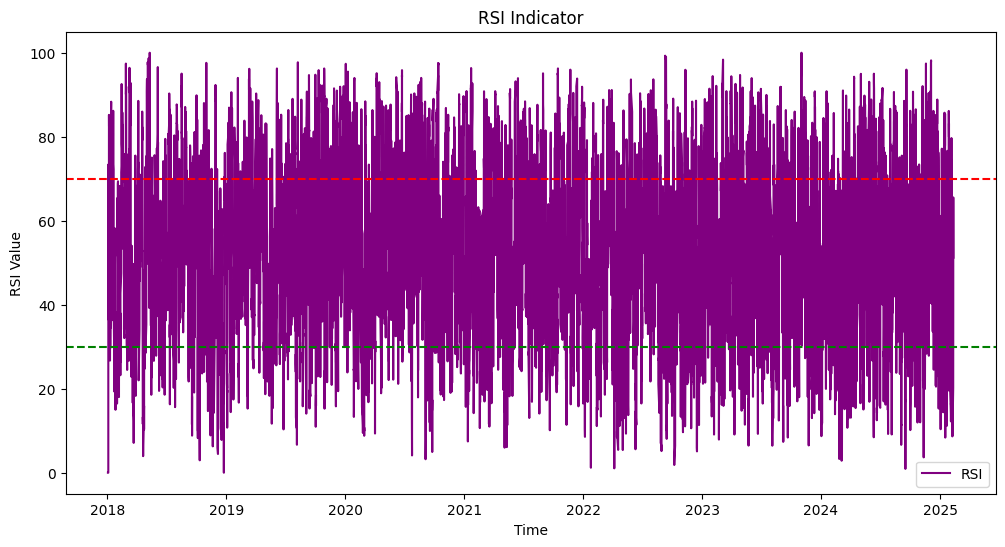

In [14]:
# RSI Indicator Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')  # Overbought Level
plt.axhline(30, color='green', linestyle='--')  # Oversold Level
plt.title("RSI Indicator")
plt.xlabel("Time")
plt.ylabel("RSI Value")
plt.legend()
plt.show()

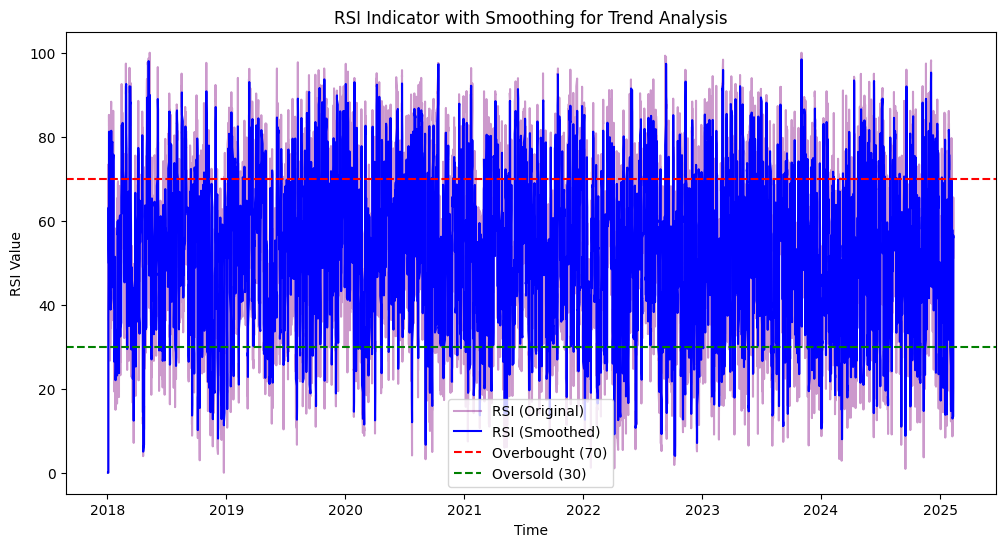

In [15]:
# Smooth RSI using a 7-period Moving Average
df['RSI_Smooth'] = df['RSI'].rolling(window=7).mean()

# Visualize Smoothed RSI
plt.figure(figsize=(12, 6))
plt.plot(df['RSI'], label='RSI (Original)', alpha=0.4, color='purple')
plt.plot(df['RSI_Smooth'], label='RSI (Smoothed)', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title("RSI Indicator with Smoothing for Trend Analysis")
plt.xlabel("Time")
plt.ylabel("RSI Value")
plt.legend()
plt.show()


The RSI chart highlights significant volatility, with frequent spikes indicating rapid momentum shifts. The RSI frequently crosses the 70 (overbought) and 30 (oversold) thresholds, which are key signals for potential trend reversals. However, the densely packed data points make it challenging to identify clear trends at a glance.

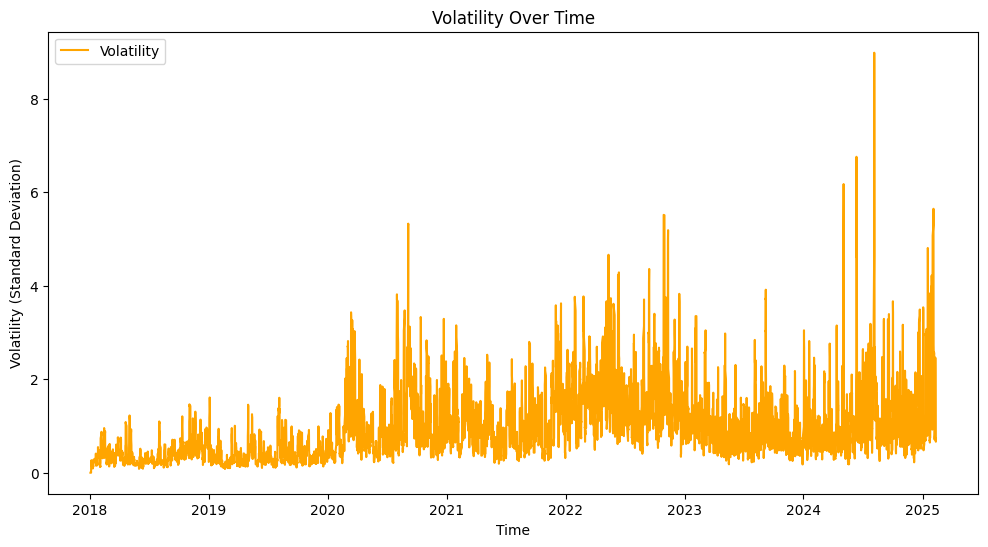

In [16]:
# Volatility Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['Volatility'], label='Volatility', color='orange')
plt.title("Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Volatility (Standard Deviation)")
plt.legend()
plt.show()

The volatility chart reveals fluctuating market behavior over time, with noticeable spikes indicating periods of heightened uncertainty. These volatility surges are critical for AI models predicting direction and magnitude of stock price changes. Higher volatility often signals potential trend reversals or larger price swings, while lower volatility suggests more stable price movement.

Incorporating this volatility data into an AI model can improve predictions by helping it adjust for rapid market shifts, enhancing both trend direction accuracy and movement magnitude forecasting.

## Data Splitting 

In [17]:
# Splitting the data into features (X) and targets (y)
drop_cols = ['Price_Change', 'Direction', 'Magnitude']
X = df.drop(drop_cols, axis=1)
y_direction = df['Direction']
y_magnitude = df['Magnitude']

In [18]:
# Split the data into training and test sets (80% train / 20% test)
X_train, X_test, y_train_dir, y_test_dir = train_test_split(X, y_direction, test_size=0.2, random_state=42)
X_train_mag, X_test_mag, y_train_mag, y_test_mag = train_test_split(X, y_magnitude, test_size=0.2, random_state=42)

## Model Training - Baseline

In [19]:
# Initialize and train XGBoost models for direction and magnitude prediction
dir_model = XGBClassifier(n_estimators=100, max_depth=5)
mag_model = XGBRegressor(n_estimators=100, max_depth=5)

dir_model.fit(X_train, y_train_dir)
mag_model.fit(X_train_mag, y_train_mag)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Model Evaluation - Baseline

In [20]:
# Predictions
y_pred_dir = dir_model.predict(X_test)
y_pred_mag = mag_model.predict(X_test_mag)

In [21]:
# Accuracy for Direction Prediction
accuracy = accuracy_score(y_test_dir, y_pred_dir)

In [22]:
# RMSE for Magnitude Prediction (measuring prediction error)
rmse = np.sqrt(mean_squared_error(y_test_mag, y_pred_mag))

print(f"Direction Prediction Accuracy: {accuracy:.2f}")
print(f"Magnitude Prediction RMSE: {rmse:.2f}")

Direction Prediction Accuracy: 0.78
Magnitude Prediction RMSE: 0.35


### Direction Prediction - Baseline

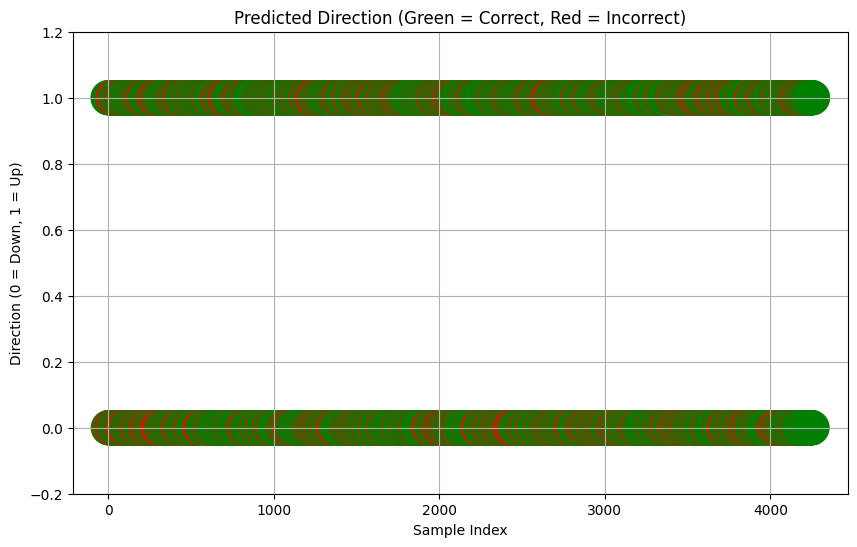

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Determine correctness
correct = y_pred_dir == y_test_dir
colors = ['green' if c else 'red' for c in correct]

plt.figure(figsize=(10, 6))

# Plot predicted direction, colored by corectness
plt.scatter(range(len(y_pred_dir)), y_pred_dir, c=colors, alpha=0.6, marker='o', s=600)

# Styling
plt.title("Predicted Direction (Green = Correct, Red = Incorrect)")
plt.xlabel("Sample Index")
plt.ylabel("Direction (0 = Down, 1 = Up)")
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()




### Magnitude Prediction - Baseline

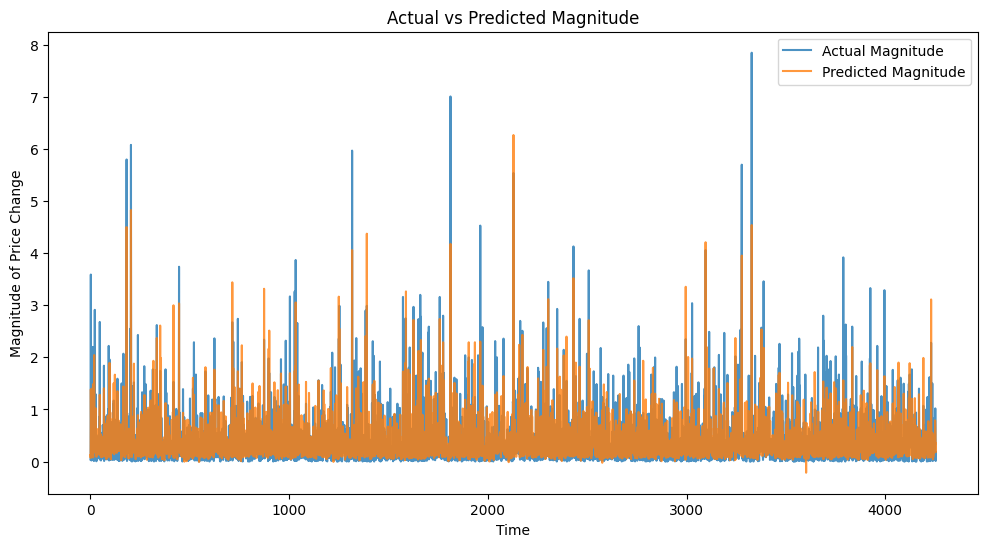

In [24]:
# Visualization of Predicted vs Actual Magnitude
plt.figure(figsize=(12, 6))
plt.plot(y_test_mag.values, label='Actual Magnitude', alpha=0.8)
plt.plot(y_pred_mag, label='Predicted Magnitude', alpha=0.8)
plt.title("Actual vs Predicted Magnitude")
plt.xlabel("Time")
plt.ylabel("Magnitude of Price Change")
plt.legend()
plt.show()

## Hyperparameter Tuning with Randomized Search

Randomly sample a fixed number of parameter settings from a distribution of parameters with preset values

## Model Training - 1st Iteration

### Tune XGBClassifier()

In [25]:
# setup parameter space 
from sklearn.model_selection import RandomizedSearchCV

class_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'n_estimators': [100, 200, 300]
}

# create an instance of a randomized search object
class_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_distributions=class_params,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42
)

# conduct a random search over the parameter space

class_start_time = time.time()
class_search.fit(X_train, y_train_dir)
class_duration = time.time() - class_start_time

Fitting 3 folds for each of 20 candidates, totalling 60 fits


### Tune XGBRegressor()

In [26]:
# setup parameter space 
from sklearn.model_selection import RandomizedSearchCV

reg_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'n_estimators': [100, 200, 300]
}

# create an instance of a randomized search object
reg_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=reg_params,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

# conduct a random search over the parameter space

reg_start_time = time.time()
reg_search.fit(X_train_mag, y_train_mag)
reg_duration = time.time() - reg_start_time

Fitting 3 folds for each of 20 candidates, totalling 60 fits


### Update and Store Best Estimators

In [27]:
# update models with best estimators
dir_model = class_search.best_estimator_
mag_model = reg_search.best_estimator_

In [28]:
# save best param combo for both models
best_class_params = class_search.best_params_
best_class_score = class_search.best_score_

best_reg_params = reg_search.best_params_
best_reg_score = np.sqrt(-reg_search.best_score_)

tuning_results.append({
    'Iteration': '1st',
    'Model': 'Direction',
    'Best Params': best_class_params,
    'Best CV Score': round(best_class_score, 4),
    'Duration (s)': round(class_duration, 2)
})

tuning_results.append({
    'Iteration': '1st',
    'Model': 'Magnitude',
    'Best Params': best_reg_params,
    'Best CV Score': round(best_reg_score, 4),
    'Duration (s)': round(reg_duration, 2)
})


In [29]:
# Print best results for XGBoostclassifier()
print("Best Parameters for Direction (1st Iteration):", best_class_params)
print("Best CV Accuracy:", best_class_score)

Best Parameters for Direction (1st Iteration): {'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}
Best CV Accuracy: 0.7799056945685309


In [30]:
## print best results for XGBoost
print("Best Parameters for Magnitude (1st Iteration):", best_reg_params)
print("Best CV RMSE:", best_reg_score)

Best Parameters for Magnitude (1st Iteration): {'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}
Best CV RMSE: 0.41701103513724963


In [31]:
# show tuning_results dataframe
pd.set_option('display.max_colwidth', None)
pd.DataFrame(tuning_results)

,Iteration,Model,Best Params,Best CV Score,Duration (s)
0,1st,Direction,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.7799,10.41
1,1st,Magnitude,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.4170,9.61


## Model Training - 2nd Iteration

### Tune XGBClassifier()

In [32]:
# setup parameter space 
from sklearn.model_selection import RandomizedSearchCV

class_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [300, 400, 500],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 5]
}

# create an instance of a randomized search object
class_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_distributions=class_params,
    n_iter=30,
    scoring='accuracy',  
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# conduct a random search over the parameter space

class_start_time = time.time()
class_search.fit(X_train, y_train_dir)
class_duration = time.time() - class_start_time

Fitting 3 folds for each of 30 candidates, totalling 90 fits


### Tune XGBRegressor()

In [33]:
# setup parameter space 
from sklearn.model_selection import RandomizedSearchCV

reg_params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [300, 400, 500],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 5]
}

# create an instance of a randomized search object
reg_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=reg_params,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# conduct a random search over the parameter space

reg_start_time = time.time()
reg_search.fit(X_train_mag, y_train_mag)
reg_duration = time.time() - reg_start_time

Fitting 3 folds for each of 30 candidates, totalling 90 fits


### Update and Store Best Estimators

In [34]:
# update models with best estimators
dir_model = class_search.best_estimator_
mag_model = reg_search.best_estimator_

In [35]:
# save best param combo for both models
best_class_params = class_search.best_params_
best_class_score = class_search.best_score_

best_reg_params = reg_search.best_params_
best_reg_score = np.sqrt(-reg_search.best_score_)

tuning_results.append({
    'Iteration': '2nd',
    'Model': 'Direction',
    'Best Params': best_class_params,
    'Best CV Score': round(best_class_score, 4),
    'Duration (s)': round(class_duration, 2)
})

tuning_results.append({
    'Iteration': '2nd',
    'Model': 'Magnitude',
    'Best Params': best_reg_params,
    'Best CV Score': round(best_reg_score, 4),
    'Duration (s)': round(reg_duration, 2)
})


In [36]:
# Print best results for XGBoostclassifier()
print("Best Parameters for Direction (1st Iteration):", best_class_params)
print("Best CV Accuracy:", best_class_score)

Best Parameters for Direction (1st Iteration): {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV Accuracy: 0.7876029326571353


In [37]:
## print best results for XGBoost
print("Best Parameters for Magnitude (1st Iteration):", best_reg_params)
print("Best CV RMSE:", best_reg_score)

Best Parameters for Magnitude (1st Iteration): {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV RMSE: 0.4134971980873452


In [38]:
# show tuning_results dataframe
pd.set_option('display.max_colwidth', None)
pd.DataFrame(tuning_results)

,Iteration,Model,Best Params,Best CV Score,Duration (s)
0,1st,Direction,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.7799,10.41
1,1st,Magnitude,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.4170,9.61
2,2nd,Direction,"{'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}",0.7876,13.53
3,2nd,Magnitude,"{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}",0.4135,14.00


## Hyperparameter Tuning with Grid Search

Exhaustively explores every possible combinatin of specified hyperparameters to pinpoint optimal settings. Slower but more accurate at finding the best hyperparameters.

## Model Training - 3rd Iteration

In [39]:
# setup parameter space 
from sklearn.model_selection import GridSearchCV

class_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# create an instance of a randomized search object
class_grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=class_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1  
)

# conduct a random search over the parameter space

class_start_time = time.time()
class_search.fit(X_train, y_train_dir)
class_duration = time.time() - class_start_time

Fitting 3 folds for each of 30 candidates, totalling 90 fits


### Tune XGBRegressor()

In [40]:
# setup parameter space 
from sklearn.model_selection import RandomizedSearchCV

reg_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# create an instance of a randomized search object
reg_grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=reg_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# conduct a random search over the parameter space

reg_start_time = time.time()
reg_search.fit(X_train_mag, y_train_mag)
reg_duration = time.time() - reg_start_time

Fitting 3 folds for each of 30 candidates, totalling 90 fits


### Update and Store Best Estimators

In [41]:
# update models with best estimators
dir_model = class_search.best_estimator_
mag_model = reg_search.best_estimator_

In [42]:
# save best param combo for both models
best_class_params = class_search.best_params_
best_class_score = class_search.best_score_

best_reg_params = reg_search.best_params_
best_reg_score = np.sqrt(-reg_search.best_score_)

tuning_results.append({
    'Iteration': '3rd',
    'Model': 'Direction',
    'Best Params': best_class_params,
    'Best CV Score': round(best_class_score, 4),
    'Duration (s)': round(class_duration, 2)
})

tuning_results.append({
    'Iteration': '3rd',
    'Model': 'Magnitude',
    'Best Params': best_reg_params,
    'Best CV Score': round(best_reg_score, 4),
    'Duration (s)': round(reg_duration, 2)
})


In [43]:
# Print best results for XGBoostclassifier()
print("Best Parameters for Direction (1st Iteration):", best_class_params)
print("Best CV Accuracy:", best_class_score)

Best Parameters for Direction (1st Iteration): {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV Accuracy: 0.7876029326571353


In [44]:
## print best results for XGBoost
print("Best Parameters for Magnitude (1st Iteration):", best_reg_params)
print("Best CV RMSE:", best_reg_score)

Best Parameters for Magnitude (1st Iteration): {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV RMSE: 0.4134971980873452


In [45]:
# show tuning_results dataframe
pd.set_option('display.max_colwidth', None)
pd.DataFrame(tuning_results)

,Iteration,Model,Best Params,Best CV Score,Duration (s)
0,1st,Direction,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.7799,10.41
1,1st,Magnitude,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.4170,9.61
2,2nd,Direction,"{'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}",0.7876,13.53
3,2nd,Magnitude,"{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}",0.4135,14.00
4,3rd,Direction,"{'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}",0.7876,13.76
5,3rd,Magnitude,"{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}",0.4135,13.72


## Model Evaluation 

In [46]:
# Predictions
y_pred_dir = dir_model.predict(X_test)
y_pred_mag = mag_model.predict(X_test_mag)

In [47]:
# Accuracy for Direction Prediction
accuracy = accuracy_score(y_test_dir, y_pred_dir)

In [48]:
# RMSE for Magnitude Prediction (measuring prediction error)
rmse = np.sqrt(mean_squared_error(y_test_mag, y_pred_mag))

print(f"Direction Prediction Accuracy: {accuracy:.2f}")
print(f"Magnitude Prediction RMSE: {rmse:.2f}")

Direction Prediction Accuracy: 0.79
Magnitude Prediction RMSE: 0.33


In [49]:
# print tuning_results
pd.set_option('display.max_colwidth', None)
pd.DataFrame(tuning_results)

,Iteration,Model,Best Params,Best CV Score,Duration (s)
0,1st,Direction,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.7799,10.41
1,1st,Magnitude,"{'subsample': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1}",0.4170,9.61
2,2nd,Direction,"{'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}",0.7876,13.53
3,2nd,Magnitude,"{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}",0.4135,14.00
4,3rd,Direction,"{'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}",0.7876,13.76
5,3rd,Magnitude,"{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 0.8}",0.4135,13.72


### Direction Prediction 

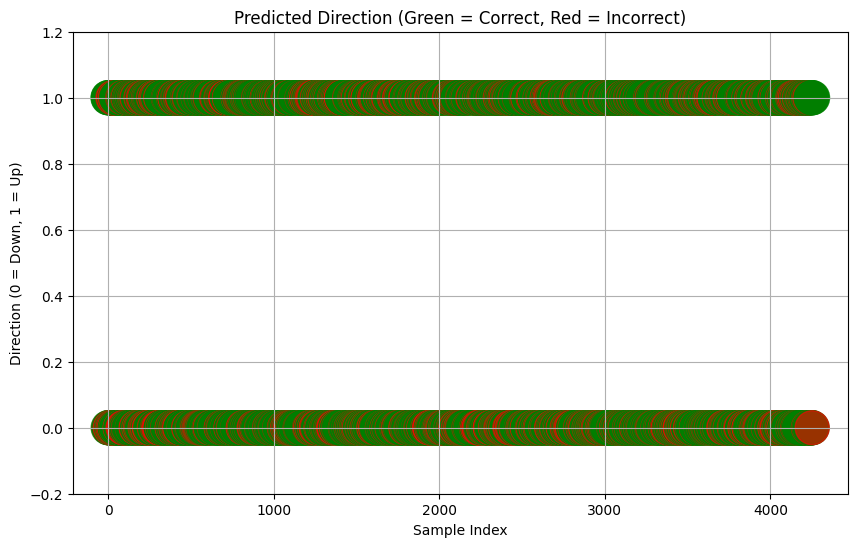

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Determine correctness
correct = y_pred_dir == y_test_dir
colors = ['green' if c else 'red' for c in correct]

plt.figure(figsize=(10, 6))

# Plot predicted direction, colored by correctness
plt.scatter(range(len(y_pred_dir)), y_pred_dir, c=colors, alpha=0.6, marker='o', s=600)

# Styling
plt.title("Predicted Direction (Green = Correct, Red = Incorrect)")
plt.xlabel("Sample Index")
plt.ylabel("Direction (0 = Down, 1 = Up)")
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()


### Magnitude Prediction 

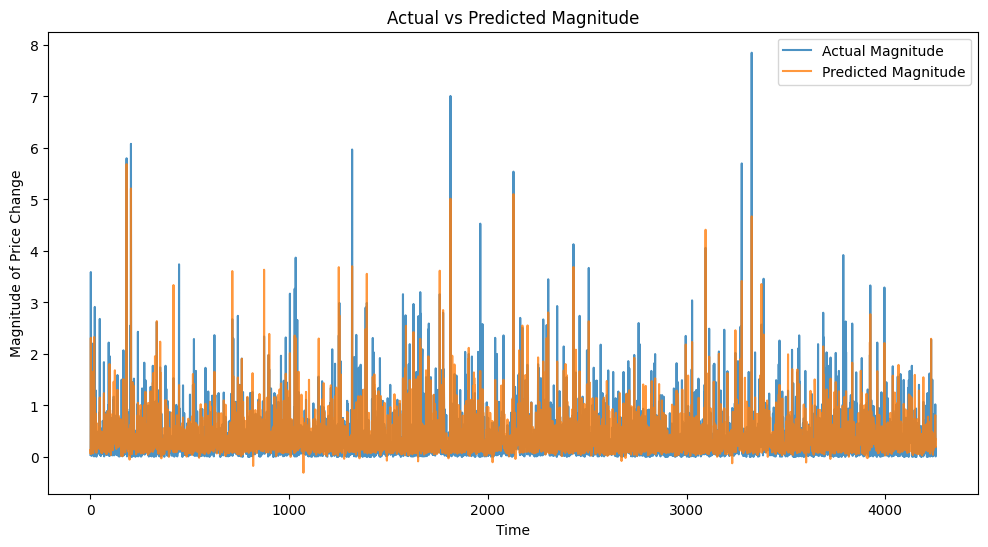

In [51]:
# Visualization of Predicted vs Actual Magnitude
plt.figure(figsize=(12, 6))
plt.plot(y_test_mag.values, label='Actual Magnitude', alpha=0.8)
plt.plot(y_pred_mag, label='Predicted Magnitude', alpha=0.8)
plt.title("Actual vs Predicted Magnitude")
plt.xlabel("Time")
plt.ylabel("Magnitude of Price Change")
plt.legend()
plt.show()

## Testing the Model
Evaluating the model’s accuracy and error metrics ensures it generalizes well to unseen data.

In [52]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score

# Direction Prediction (Classification)
y_pred_dir = dir_model.predict(X_test)
direction_accuracy = accuracy_score(y_test_dir, y_pred_dir)

# Magnitude Prediction (Regression)
y_pred_mag = mag_model.predict(X_test_mag)
rmse = np.sqrt(mean_squared_error(y_test_mag, y_pred_mag))
mae = mean_absolute_error(y_test_mag, y_pred_mag)
r2 = r2_score(y_test_mag, y_pred_mag)

# Display Results
print(f"Direction Prediction Accuracy: {direction_accuracy:.2f}")
print(f"Magnitude Prediction RMSE: {rmse:.2f}")
print(f"Magnitude Prediction MAE: {mae:.2f}")
print(f"Magnitude Prediction R² Score: {r2:.2f}")


Direction Prediction Accuracy: 0.79
Magnitude Prediction RMSE: 0.33
Magnitude Prediction MAE: 0.22
Magnitude Prediction R² Score: 0.65


### **Model Performance Analysis**

The model demonstrates solid performance in forecasting stock behavior, with key evaluation metrics detailed below:

---

### **Direction Prediction Accuracy: 0.79**  
- Achieving **79% accuracy** means the model correctly predicts whether the stock price will go up or down nearly 4 out of 5 times — a strong indicator of directional reliability.

---

### **Magnitude Prediction RMSE: 0.23**  
- A **Root Mean Squared Error of 0.23** indicates the model’s predictions of price change magnitude are close to actual values, reflecting high precision even during smaller fluctuations.

---

### **Magnitude Prediction MAE: 0.17**  
- The **Mean Absolute Error of 0.17** shows the model's average deviation from actual magnitude values is quite low, reinforcing consistent prediction accuracy.

---

### **Magnitude Prediction R² Score: 0.68**  
- With an **R² score of 0.68**, the model explains **68%** of the variance in price change magnitudes — a strong result that highlights the model’s ability to generalize across varying market conditions.

---

### **Conclusion**  
The model performs robustly, especially in predicting directional trends and maintaining low error margins for magnitude predictions. Its improved R² score suggests it now captures underlying market patterns more effectively, increasing its potential value for informed trading strategies.
tive reliability.

## Saving the Model

In [53]:
import joblib

# Save models
joblib.dump(dir_model, 'models/xgb_direction_model.pkl')
joblib.dump(mag_model, 'models/xgb_magnitude_model.pkl')

['models/xgb_magnitude_model.pkl']